# <font size=5> 모멘텀 추세 추종 전략</font>

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import ta

## 📈 모멘텀 전략(Momentum Strategy)

모멘텀 전략은 "상승하는 자산은 더 오르고, 하락하는 자산은 더 하락한다"는 시장의 관찰에 기반한 전략입니다.  
과거 일정 기간 동안 좋은 성과를 낸 자산에 투자하고, 성과가 나쁜 자산은 회피하거나 반대로 베팅합니다.

## 🔍 핵심 개념

- **모멘텀(Momentum)**: 일정 기간 동안의 가격 변화율 또는 수익률 M(t) = (p(t)-p(t-n))/p(t-n)
  1. 절대 모멘텀: 개별 주식의 일정 기간 동안의 수익률
  2. 상대 모멘텀: 여러 종목 간 일정 기간 동안의 수익률의 비교
- **전략 목적**: 상승 추세에 있는 자산을 따라가 수익 극대화
- **기초 가정**: 시장에는 추세가 존재하며, 일정 기간 동안 지속되는 경향이 있음


[*********************100%***********************]  1 of 1 completed


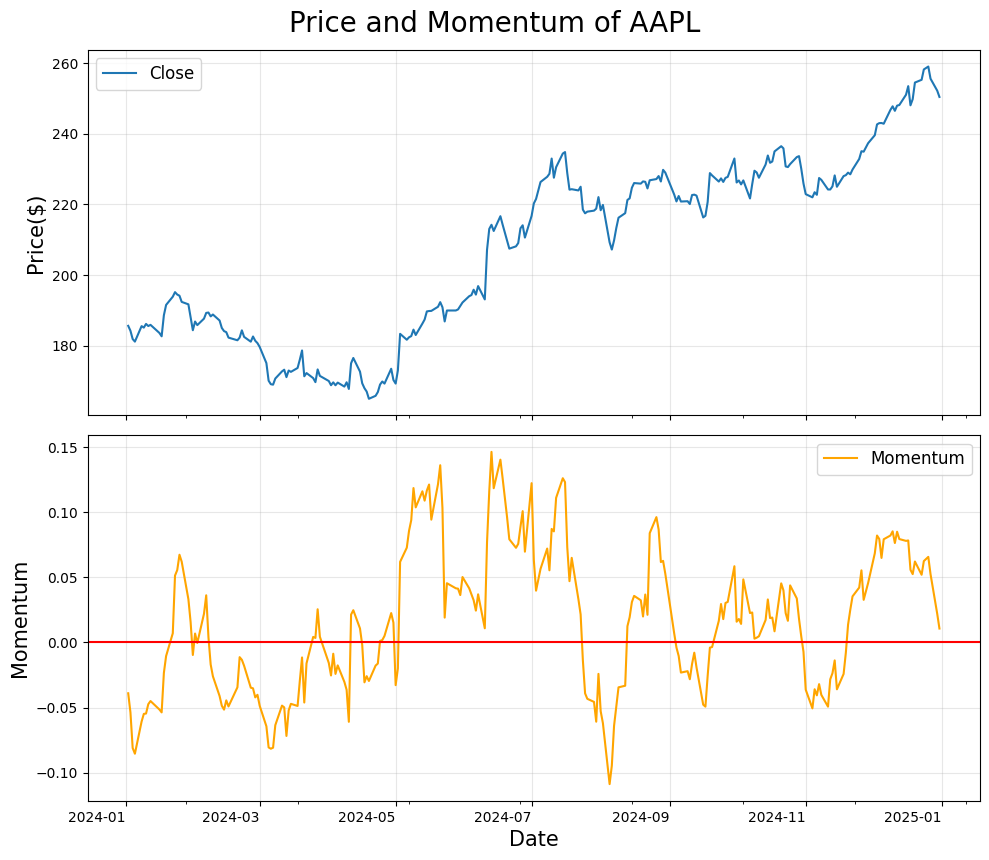

In [4]:
#AAPL에 대한 주가와 모멘텀 그래프

# 주가 데이터 다운로드
ticker = "AAPL"
start_date = "2019-01-01"
end_date = "2025-01-01"
df = yf.download(ticker, start_date, end_date, multi_level_index=False, auto_adjust=False)

# 모멘텀 지표 계산
data = df.copy()
period = 14
data['Mom'] = data['Close'].pct_change(periods=period)

# 모멘텀 그래프 그리기
fig, ax = plt.subplots(2, 1, figsize=(10, 9), sharex=True)

start = '2024-01-01'
end = '2025-01-01'

data['Close'].loc[start:end].plot(ax=ax[0], label='Close')
ax[0].set_ylabel('Price($)',fontsize=15)
ax[0].grid(alpha=0.3)
ax[0].legend(fontsize=12, loc='best')

data['Mom'].loc[start:end].plot(ax=ax[1], label='Momentum', color='orange')
ax[1].axhline(y=0, color='red', linestyle='-')
ax[1].set_xlabel('Date', fontsize=15)
ax[1].set_ylabel('Momentum',fontsize=15)
ax[1].grid(alpha=0.3)
ax[1].legend(fontsize=12, loc='best')

plt.suptitle(f'Price and Momentum of {ticker}', fontsize=20)
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

모멘텀 추세 추종 전략1
1. 적절한 기간(n값)을 정하고 모멘텀 계산
2. 모멘텀이 음에서 양으로 변하면 매수
3. 추적 손절법에 따라 매도

In [17]:
#모멘텀 추세추종 전략 백테스팅 함수1

def mom_strategy1(df, p, sl, monthly_invest=100, verbose=True):
    fee_rate = 0.001
    data = df.copy()
    period = p
    stop_loss = sl

    data['Mom'] = data['Close'].pct_change(periods=period)
    data.dropna(inplace=True)

    data['Month'] = data.index.to_series().dt.to_period('M')  # 월 구분용
    monthly_flags = data['Month'] != data['Month'].shift(1)  # 월이 바뀌는 시점만 True

    mom_pos = pd.Series(np.where(data['Mom'] > 0, 1, 0), index=data.index)
    mom_signals = mom_pos.diff().fillna(0)

    cash_init = 10000
    cash = cash_init
    asset = np.zeros(len(data))
    asset[0] = cash

    prices = data['Close'].values
    signals = mom_signals.values
    positions = np.zeros(len(data))
    pos = 0
    num = 0  # 보유 주식 수

    for i in range(1, len(data)):
        # 🔁 월이 바뀌면 $100 추가
        if monthly_flags.iloc[i]:
            cash += monthly_invest

        if pos == 0:
            if signals[i] == 1:
                pos = 1
                positions[i] = 1
                entry_price = prices[i]
                num = int(cash / (entry_price * (1 + fee_rate)))
                cash -= entry_price * num * (1 + fee_rate)
                stop_loss_price = entry_price * (1 - stop_loss)
        elif pos == 1:
            if prices[i] < stop_loss_price:
                pos = 0
                cash += prices[i] * num * (1 - fee_rate)
                num = 0
            else:
                positions[i] = 1
                stop_loss_price = max(stop_loss_price, prices[i] * (1 - stop_loss))

        # 자산 평가
        if pos == 0:
            asset[i] = cash
        elif pos == 1:
            asset[i] = cash + prices[i] * num

    # 결과 기록
    data['Position'] = positions
    data['Signal'] = data['Position'].diff().fillna(0)
    data['Buy_Price'] = np.where(data['Signal'] == 1, data['Close'], np.nan)
    data['Sell_Price'] = np.where(data['Signal'] == -1, data['Close'], np.nan)
    data['Cumulative_Return'] = asset / cash_init
    final_cum_return = data['Cumulative_Return'].iloc[-1] - 1

    if verbose:
        print(f'Final cumulative return of the strategy: {100 * final_cum_return:.2f}%')

    return data, final_cum_return


In [11]:
#기술 평가 함수

def tear_sheet1(data):
    fee_rate = 0.001
    
    # 투자기간 Trading Period in Years
    trading_period = len(data)/252 # in year
    print(f'Trading Period:{trading_period:.1f} years')    
    
    # 수익률 Rate of Return
    buy_and_hold = data['Close'].iloc[-1]*(1-fee_rate)\
    /(data['Close'].iloc[0]*(1+fee_rate)) - 1
    final_cum_return = data['Cumulative_Return'].iloc[-1] - 1
    print(f'Final cumulative return of the strategy:'
    f'{100*final_cum_return:.2f}%, Buy&Hold:{100*buy_and_hold:.2f}%')
    
    # 연평균 성장률 CAGR   
    CAGR_strategy = (data['Cumulative_Return'].iloc[-1])**(1/trading_period)-1
    CAGR_benchmark = (buy_and_hold+1)**(1/trading_period)-1
    print(f'Strategy CAGR:{100*CAGR_strategy:.2f}%, '
           f'Benchmark CAGR:{100*CAGR_benchmark:.2f}%')
    
    # 샤프 지수 Sharpe Ratio
    risk_free_rate = 0.003
    strategy_daily_return = data['Cumulative_Return'].pct_change().fillna(0)
    mean_return = strategy_daily_return.mean()*252
    std_return = strategy_daily_return.std()*np.sqrt(252)
    sharpe_ratio = (mean_return - risk_free_rate) / std_return
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
    
    # 최대 낙폭 Maximum Drawdown
    data['Cumulative_Max'] = data['Cumulative_Return'].cummax()
    data['Drawdown'] = data['Cumulative_Return'] / data['Cumulative_Max'] - 1
    max_drawdown = data['Drawdown'].min()
    cumulative_returns = (1 + data['Close'].pct_change()).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = cumulative_returns/running_max - 1
    mdd_benchmark = drawdown.min() 
    print(f'Strategy MDD: {100*max_drawdown:.2f}%, '
          f'Benchmark MDD: {100*mdd_benchmark:.2f}%')   

    # 승률 Win Rate
    buy_signals = data[data['Signal'] == 1].index
    sell_signals = data[data['Signal'] == -1].index
    returns = []
    holding_periods = []
    for buy_date in buy_signals:
        sell_dates = sell_signals[sell_signals > buy_date]
        if not sell_dates.empty:
            sell_date = sell_dates[0]
            buy_price = data.loc[buy_date, 'Close']
            sell_price = data.loc[sell_date, 'Close']
            return_pct = sell_price*(1-fee_rate)/(buy_price*(1+fee_rate)) - 1
            returns.append(return_pct)          
            holding_period = np.busday_count(buy_date.date(), sell_date.date())
            holding_periods.append(holding_period)
    profitable_trades = len([r for r in returns if r > 0])
    loss_trades = len([r for r in returns if r <= 0])
    total_trades = len(returns)
    win_rate = profitable_trades / total_trades if total_trades > 0 else 0
    print(f'Number of Profitable Trades:{profitable_trades}, '
    f'Number of Loss Trades:{loss_trades}, Win Rate:{100*win_rate:.2f}%')
    
    # 평균 보유 기간 Average Holding Period
    if holding_periods:
        average_holding_period = np.mean(holding_periods)
    else:
        average_holding_period = 0
    print(f'Average Holding Period:{average_holding_period:.1f}days')

    #자본을 정직적으로 추가 할대는 XIRR을 이용해 평가하는 것이 더 좋음 -> 추후 구현

    # 평균 이익과 손실 계산 Calculation of Average Profit and Loss
    if profitable_trades > 0:
        average_profit = np.mean([r for r in returns if r > 0])
    else:
        average_profit = 0
    
    if loss_trades > 0:
        average_loss = np.mean([r for r in returns if r <= 0])
    else:
        average_loss = 0
    print(f'Avg ROR/trade in profitable trades:{average_profit:.3f}%, '
          f'Avg ROR/trade in loss trades:{average_loss:.3f}%')
    
    # 이익 손실 비율 계산 Calculation of Profit/Loss Ratio
    if average_loss != 0:
        profit_loss_ratio = average_profit / abs(average_loss)
    else:
        profit_loss_ratio = np.inf  # If there are no losses, the ratio is infinitely large.
    
    print(f'Profit/Loss Ratio: {profit_loss_ratio:.2f}')

In [8]:
#파라미터 최적화 함수

def mom_parameter_optimizer1(input_df):
    period = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,\
              16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
    stop_loss = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,\
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2] 
    ret_list = []  

    for x1, x2, in [(a,b) for a in period for b in stop_loss]:
        df = input_df.copy()
        data, ror = mom_strategy1(df, x1, x2, verbose=False)
        ret_list.append((x1, x2, ror))

    max_ror = max(ret_list, key=lambda x:x[2])[2]
    max_tups = [tup for tup in ret_list if tup[2] == max_ror]
    params1 = [tup[0] for tup in max_tups]
    params2 = [tup[1] for tup in max_tups]
    opt_param1 = int(np.median(params1))
    opt_param2 = round(np.median(params2),4)

    optimal_df = pd.DataFrame(ret_list, \
                columns=['period','stop_loss','ror'])
    print(f'Max Tuples:{max_tups}')
    print(f'Optimal Parameters:{opt_param1, opt_param2}, '
    f'Optimized Return:{100*max_ror:.2f}%')

    return (opt_param1, opt_param2), optimal_df

#백테스팅 진행
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2024-01-01'
df = yf.download(ticker, start=start_date, end=end_date, multi_level_index=False, auto_adjust=False)

opt_params, opt_df = mom_parameter_optimizer1(df)

data, ret = mom_strategy1(df, opt_params[0], opt_params[1])
tear_sheet1(data)

[*********************100%***********************]  1 of 1 completed


Max Tuples:[(20, 0.08, np.float64(2.4864475253082303))]
Optimal Parameters:(20, np.float64(0.08)), Optimized Return:248.64%
Final cumulative return of the strategy: 248.64%
Trading Period:3.9 years
Final cumulative return of the strategy:248.64%, Buy&Hold:148.32%
Strategy CAGR:37.60%, Benchmark CAGR:26.17%
Sharpe Ratio: 1.46
Strategy MDD: -20.32%, Benchmark MDD: -31.43%
Number of Profitable Trades:7, Number of Loss Trades:6, Win Rate:53.85%
Average Holding Period:49.9days
Avg ROR/trade in profitable trades:0.228%, Avg ROR/trade in loss trades:-0.058%
Profit/Loss Ratio: 3.90


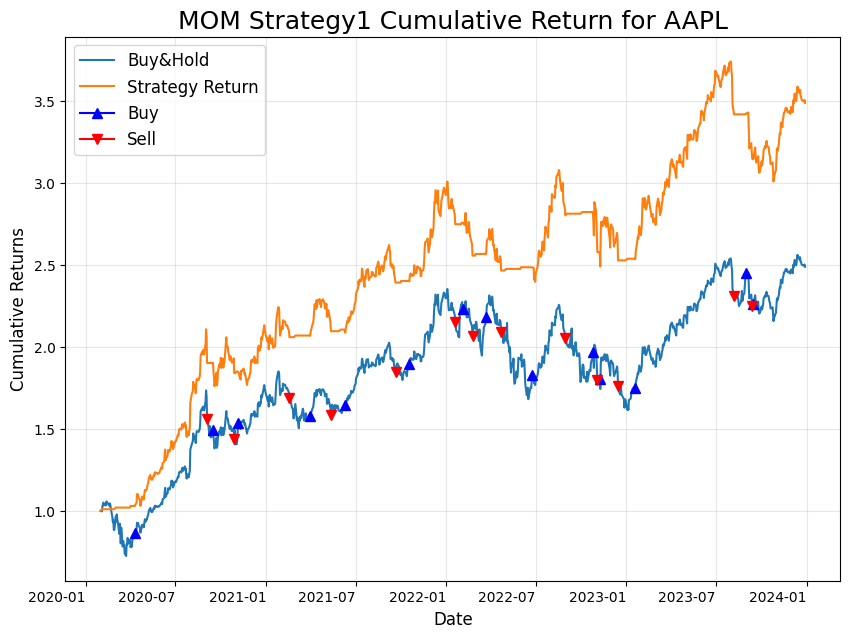

In [9]:
#전략1 백테스팅 누적 수익률 시각화

buy_and_hold = data['Close']/data['Close'].iloc[0]
buy_price = data['Buy_Price']/data['Close'].iloc[0]
sell_price = data['Sell_Price']/data['Close'].iloc[0]

fig, ax = plt.subplots(figsize=(10, 8))

buy_and_hold.plot(ax=ax, label='Buy&Hold')
data['Cumulative_Return'].plot(ax=ax, label='Strategy Return')
buy_price.plot(ax=ax, label='Buy', marker='^', color='b', markersize=7)
sell_price.plot(ax=ax, label='Sell', marker='v', color='r', markersize=7)

ax.set_title(f'MOM Strategy1 Cumulative Return for {ticker}', fontsize=18)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Returns', fontsize=12)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)
plt.xticks(rotation=0)
plt.show()

## 📈 모멘텀 추세 추종 전략 2: 보조 지표 활용

### 1. MFI (Money Flow Index)
- 가격과 거래량을 사용해 **과매수**, **과매도** 상태를 파악하는 보조 지표
- **계산 방법**:
  1. `Typical Price (TP) = (고가 + 저가 + 종가) / 3`
  2. `Raw Money Flow = TP × 거래량`
  3. `Positive / Negative Money Flow`:  
     - TP가 전일보다 높으면 *Positive*,  
     - TP가 전일보다 낮으면 *Negative*
  4. `Money Flow Ratio = (Positive MF 합) / (Negative MF 합)`
  5. `MFI = 100 - [100 / (1 + Money Flow Ratio)]`

- **해석**:
  - `MFI ≈ 100` → 과매수 상태
  - `MFI ≈ 0` → 과매도 상태
  - 특정 MFI 기준값(`mfi_level`)을 활용하여 *가짜 매수 신호*를 걸러낼 수 있음

---

### 2. 전략 구성

-적절한 기간(p1)을 정하고 모멘텀 계산, 적절한 기간(p2)를 정하고 MFI 계산

-✅ 매수 조건: 모멘텀이 **양전**할 것 (음수 → 양수 전환), `MFI > mfi_level`일 것

-❌ 매도 조건: 추적 손절법(Trailing Stop Loss)을 통해 **손절률(sl)** 이상 하락 시 매도

   

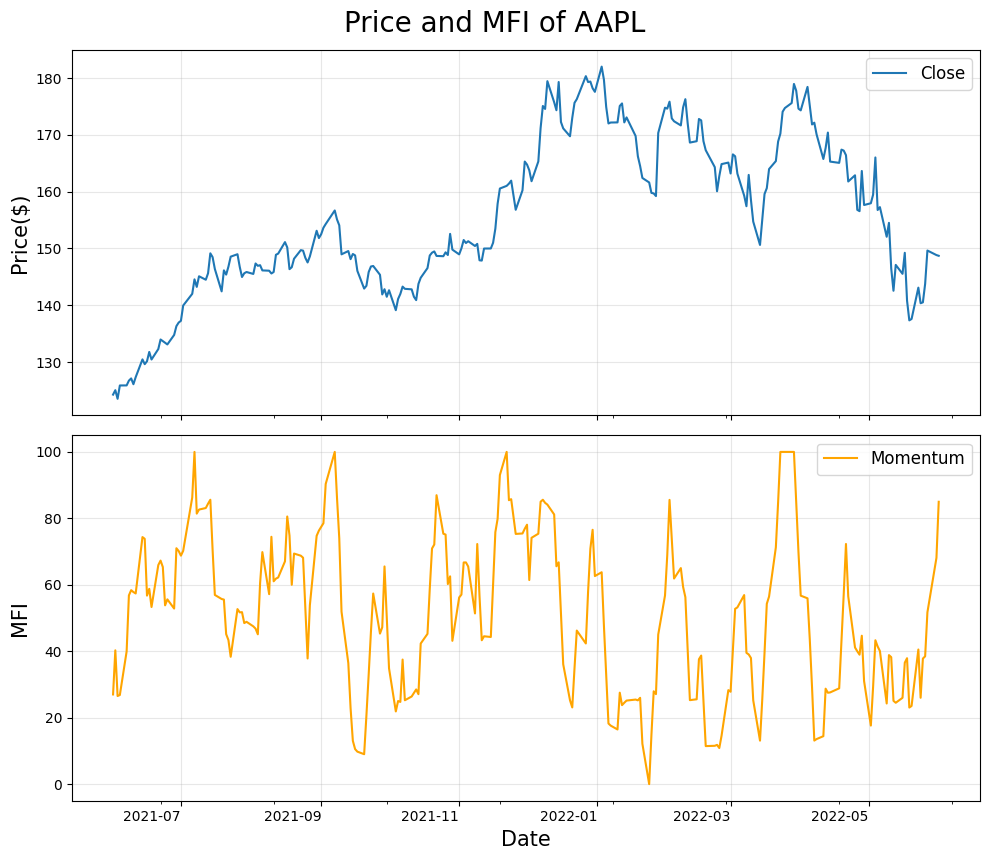

In [11]:
# AAPL에 대한 주가와 MFI 그래프

# MFI지표 계산
data = df.copy()
period = 7
data['MFI'] = \
ta.volume.money_flow_index(data.High,data.Low,data.Close,data.Volume,period)

# 그래프 그리기
fig, ax = plt.subplots(2, 1, figsize=(10, 9), sharex=True)

start = '2021-06-01'
end = '2022-06-01'

data['Close'].loc[start:end].plot(ax=ax[0], label='Close')
ax[0].set_ylabel('Price($)',fontsize=15)
ax[0].grid(alpha=0.3)
ax[0].legend(fontsize=12, loc='upper right')

data['MFI'].loc[start:end].plot(ax=ax[1], label='Momentum', color='orange')
ax[1].set_xlabel('Date', fontsize=15)
ax[1].set_ylabel('MFI',fontsize=15)
ax[1].grid(alpha=0.3)
ax[1].legend(fontsize=12, loc='upper right')

plt.suptitle(f'Price and MFI of {ticker}', fontsize=20)
plt.tight_layout()
plt.xticks(rotation=0)
# plt.savefig('mom_05.png', dpi=300)
plt.show()

In [12]:
ticker = 'TSLA'
start_date = '2018-12-01'
# start_date = '2024-01-01'
end_date = '2024-01-01'
# end_date = '2024-06-30'
df = yf.download(ticker, start=start_date, end=end_date,multi_level_index=False, auto_adjust=False)

df['MFI'] = ta.volume.money_flow_index(df.High,df.Low,df.Close,df.Volume,7)

#날짜 기반 슬라이싱 데이터프레임 복제
df = df.loc['2019-01-01':].copy()

opt_params, opt_df = mom_parameter_optimizer1(df)

data, ret = mom_strategy1(df, opt_params[0], opt_params[1])
tear_sheet1(data)

[*********************100%***********************]  1 of 1 completed


Max Tuples:[(18, 0.13, np.float64(25.855177452221525))]
Optimal Parameters:(18, np.float64(0.13)), Optimized Return:2585.52%
Final cumulative return of the strategy: 2585.52%
Trading Period:4.9 years
Final cumulative return of the strategy:2585.52%, Buy&Hold:1150.51%
Strategy CAGR:95.17%, Benchmark CAGR:67.09%
Sharpe Ratio: 1.66
Strategy MDD: -32.21%, Benchmark MDD: -73.63%
Number of Profitable Trades:10, Number of Loss Trades:10, Win Rate:50.00%
Average Holding Period:37.8days
Avg ROR/trade in profitable trades:0.650%, Avg ROR/trade in loss trades:-0.119%
Profit/Loss Ratio: 5.47


In [13]:
data, ror = mom_strategy1(df, opt_params[0], opt_params[1])

Final cumulative return of the strategy: 2585.52%


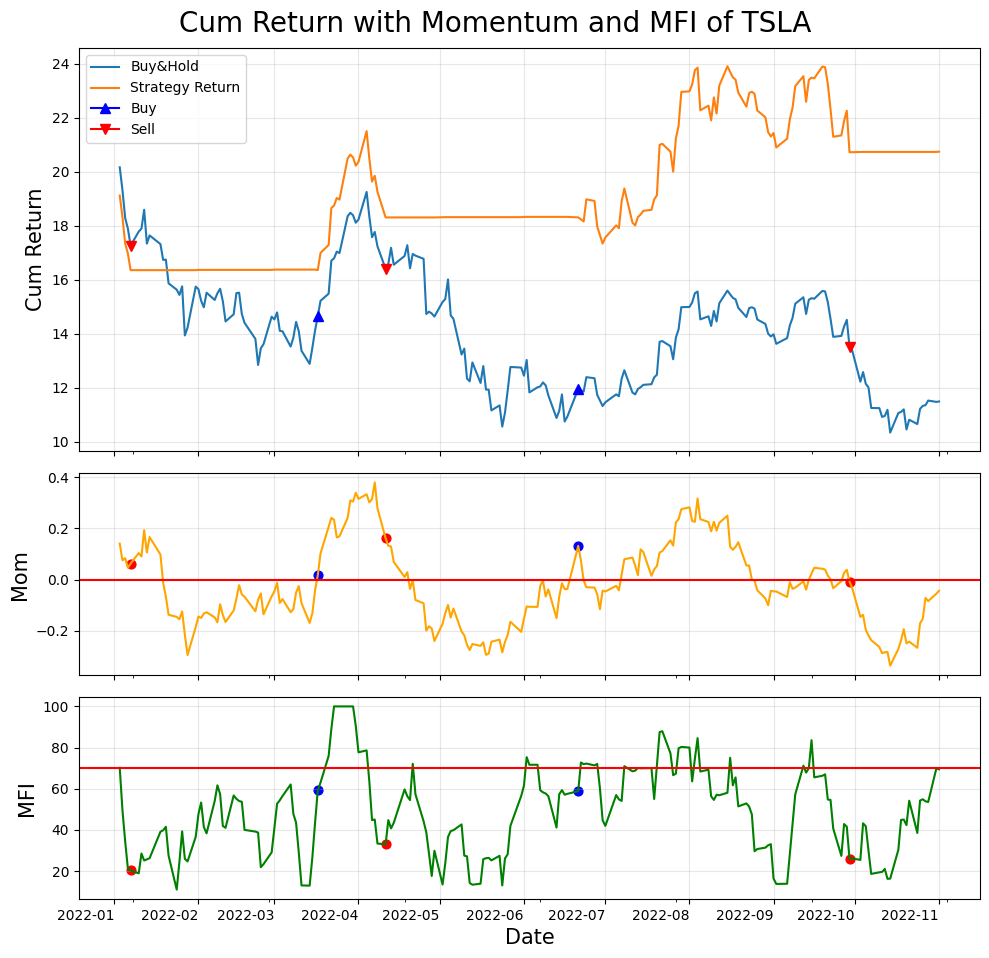

In [14]:
#MOM Strategy1 백테스트 결과와 MFI 시각화

buy_and_hold = data['Close']/data['Close'].iloc[0]
buy_price = data['Buy_Price']/data['Close'].iloc[0]
sell_price = data['Sell_Price']/data['Close'].iloc[0]

fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True, height_ratios=(5,2.5,2.5))

start = '2022-01-01'
end = '2022-11-01'

buy_and_hold.loc[start:end].plot(ax=ax[0], label='Buy&Hold')
data['Cumulative_Return'].loc[start:end].plot(ax=ax[0], label='Strategy Return')
buy_price.loc[start:end].plot(ax=ax[0], label='Buy', marker='^', color='b', markersize=7)
sell_price.loc[start:end].plot(ax=ax[0], label='Sell', marker='v', color='r', markersize=7)
ax[0].set_ylabel('Cum Return',fontsize=15)
ax[0].grid(alpha=0.3)
ax[0].legend()

buy_signals = data.loc[start:end].dropna(subset=['Buy_Price'])
sell_signals = data.loc[start:end].dropna(subset=['Sell_Price'])

data['Mom'].loc[start:end].plot(ax=ax[1], label='Momentum', color='orange')
ax[1].axhline(y=0, color='red', linestyle='-')
ax[1].scatter(buy_signals.index, buy_signals['Mom'], color='blue', s=40, label='_nolegend_')
ax[1].scatter(sell_signals.index, sell_signals['Mom'], color='red', s=40, label='_nolegend_')
ax[1].set_ylabel('Mom',fontsize=15)
ax[1].grid(alpha=0.3)

data['MFI'].loc[start:end].plot(ax=ax[2], label='MFI', color='green')
ax[2].axhline(y=70, color='red', linestyle='-')
ax[2].scatter(buy_signals.index, buy_signals['MFI'], color='blue', s=40, label='_nolegend_')
ax[2].scatter(sell_signals.index, sell_signals['MFI'], color='red', s=40, label='_nolegend_')
ax[2].set_xlabel('Date', fontsize=15)
ax[2].set_ylabel('MFI',fontsize=15)
ax[2].grid(alpha=0.3)

plt.suptitle(f'Cum Return with Momentum and MFI of {ticker}', fontsize=20)
plt.tight_layout()
plt.xticks(rotation=0)
plt.savefig('mom_06.png', dpi=300)
plt.show()

In [5]:
#MOM Strategy2의 백테스트 함수

def mom_strategy2(df, p1, p2, ml, sl, verbose=True):
    fee_rate = 0.001
    data = df.copy()

    period1 = p1
    period2 = p2
    mfi_level = ml
    stop_loss = sl
    
    data['Mom'] = data['Close'].pct_change(periods=period1)
    data['MFI'] = ta.volume.money_flow_index(data.High, \
                data.Low, data.Close, data.Volume, period2) 
    data.dropna(inplace=True)

    mom_pos = pd.Series(np.where(data['Mom']>0, 1, 0), \
                        index=data.index)
    mom_signals = mom_pos.diff().fillna(0)

    cash_init = 10000
    cash = cash_init
    asset = np.zeros(len(data))
    asset[0] = cash

    prices = data['Close'].values
    signals = mom_signals.values
    mfi = data['MFI'].values
    positions = np.zeros(len(data))
    pos = 0    
    
    for i in range(1, len(data)):
        if pos == 0:
            if signals[i] == 1 and mfi[i] > mfi_level: # 매수
                pos = 1
                positions[i] = 1
                entry_price = prices[i]
                num = int(cash/(entry_price*(1+fee_rate)))
                cash -= entry_price*num*(1+fee_rate)
                stop_loss_price = entry_price*(1 - stop_loss)
        elif pos == 1:
            if prices[i] < stop_loss_price: # 손절 발생
                pos = 0
                cash += prices[i]*num*(1-fee_rate)  
            else: # 손절가 갱신
                positions[i] = 1
                stop_loss_price =\
                max(stop_loss_price, prices[i]*(1 - stop_loss))

        # asset 갱신
        if pos == 0:
            asset[i] = cash
        elif pos == 1:
            asset[i] = cash + prices[i]*num    

    data['Position'] = positions
    data['Signal'] = data['Position'].diff().fillna(0)
    
    data['Buy_Price'] = \
    np.where(data['Signal'] == 1, data['Close'], np.nan)
    data['Sell_Price'] = \
    np.where(data['Signal'] == -1, data['Close'], np.nan)   
    
    data['Cumulative_Return'] = asset/cash_init
    final_cum_return = data['Cumulative_Return'].iloc[-1] - 1
    if verbose:
        print(f'Final cumulative return of the strategy: '
          f'{100*final_cum_return:.2f}%')
    return data, final_cum_return

In [7]:
#MOM Strategy2의 파라미터 최적화

def mom_parameter_optimizer2(input_df):
    period1 = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    period2 = [3, 4, 5, 6, 7, 8, 9, 10]
    mfi_level = [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,\
                 56, 57, 58]
    stop_loss = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12,\
                 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]  
    ret_list = []  

    for x1, x2, x3, x4 in [(a,b,c,d) for a in period1 for b in \
                period2 for c in mfi_level for d in stop_loss]:
        df = input_df.copy()
        data, ror = mom_strategy2(df, x1, x2, x3, x4, verbose=False)
        ret_list.append((x1, x2, x3, x4, ror))

    max_ror = max(ret_list, key=lambda x:x[4])[4]
    max_tups = [tup for tup in ret_list if tup[4] == max_ror]
    params1 = [tup[0] for tup in max_tups]
    params2 = [tup[1] for tup in max_tups]
    params3 = [tup[2] for tup in max_tups]
    params4 = [tup[3] for tup in max_tups]    
    opt_param1 = int(np.median(params1))
    opt_param2 = int(np.median(params2))
    opt_param3 = round(np.median(params3),1)
    opt_param4 = round(np.median(params4),4)    

    optimal_df = pd.DataFrame(ret_list, columns=
                ['period1','period2', 'mfi_level', 'stop_loss','ror'])
    print(f'Max Tuples:{max_tups}')
    print(f'Optimal Parameters:'
    f'{opt_param1, opt_param2, opt_param3, opt_param4}, '
    f'Optimized Return:{100*max_ror:.2f}%')

    return (opt_param1, opt_param2, opt_param3, opt_param4), optimal_df

In [13]:
ticker = 'TSLA'
start_date = '2019-01-01'
end_date = '2024-01-01'
df = yf.download(ticker, start=start_date, end=end_date,multi_level_index=False, auto_adjust=False)

import time
t1 = time.time()

opt_params, optimal_df = mom_parameter_optimizer2(df)

t2 = time.time()
print(f'Elapsed Time:{(t2-t1)/60:.2f}min')

data, ret = mom_strategy2(df, opt_params[0], opt_params[1], \
                          opt_params[2], opt_params[3])
tear_sheet1(data)

[*********************100%***********************]  1 of 1 completed


Max Tuples:[(6, 9, 57, 0.1, np.float64(51.78925763215573))]
Optimal Parameters:(6, 9, np.float64(57.0), np.float64(0.1)), Optimized Return:5178.93%
Elapsed Time:12.94min
Final cumulative return of the strategy: 5178.93%
Trading Period:5.0 years
Final cumulative return of the strategy:5178.93%, Buy&Hold:1012.37%
Strategy CAGR:122.47%, Benchmark CAGR:62.53%
Sharpe Ratio: 2.23
Strategy MDD: -29.92%, Benchmark MDD: -73.63%
Number of Profitable Trades:8, Number of Loss Trades:5, Win Rate:61.54%
Average Holding Period:39.8days
Avg ROR/trade in profitable trades:0.789%, Avg ROR/trade in loss trades:-0.079%
Profit/Loss Ratio: 10.01


In [19]:
data1, ror = mom_strategy1(df, 18, 0.13)

Final cumulative return of the strategy: 2585.52%


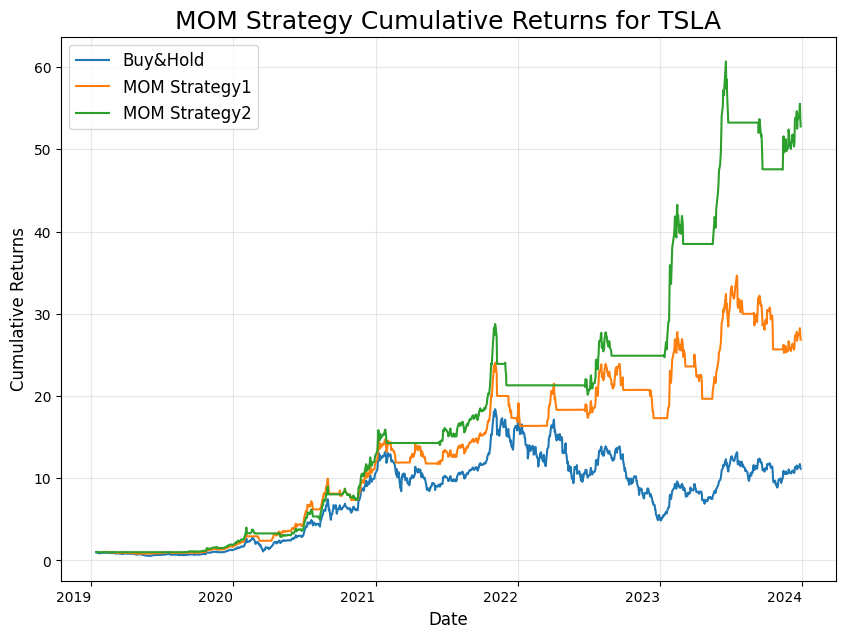

In [21]:
buy_and_hold = data['Close']/data['Close'].iloc[0]

fig, ax = plt.subplots(figsize=(10, 8))

buy_and_hold.plot(ax=ax, label='Buy&Hold')
data1['Cumulative_Return'].plot(ax=ax, label='MOM Strategy1')
data['Cumulative_Return'].plot(ax=ax, label='MOM Strategy2')

ax.set_title(f'MOM Strategy Cumulative Returns for {ticker}', fontsize=18)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Returns', fontsize=12)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)
plt.xticks(rotation=0)
plt.show()

전략 검증 by rolling test

In [28]:
from datetime import datetime
def rolling_test2(ticker, date):
    # 전체 데이터 다운로드
    middle_date = date
    middle_date_dt = datetime.strptime(middle_date, '%Y-%m-%d')
    
    start_date_dt = middle_date_dt.replace(year=middle_date_dt.year - 5)
    start_date = start_date_dt.strftime('%Y-%m-%d')   
    
    end_date_dt = middle_date_dt.replace(year=middle_date_dt.year + 2)
    end_date = end_date_dt.strftime('%Y-%m-%d')
    
    df = yf.download(ticker, start_date, end_date,multi_level_index=False, auto_adjust=False)

    # 파라미터 최적화와 백테스트
    df_train = df.loc[:middle_date].copy()
    opt_params, optimal_df = mom_parameter_optimizer2(df_train)   
    
    df_test = df.loc[middle_date:].copy()
    data, ret = mom_strategy2(df_test, opt_params[0], opt_params[1], opt_params[2], opt_params[3])

    # 연평균 성장률 CAGR
    fee_rate = 0.001
    trading_period = len(data)/252 # in years   
    buy_and_hold = data['Close'].iloc[-1]*(1-fee_rate)\
    /(data['Close'].iloc[0]*(1+fee_rate))
    CAGR_strategy = (data['Cumulative_Return'].iloc[-1])**(1/trading_period)-1
    CAGR_benchmark = (buy_and_hold)**(1/trading_period)-1

    # 최대 낙폭 Maximum Drawdown
    data['Cumulative_Max'] = data['Cumulative_Return'].cummax()
    data['Drawdown'] = data['Cumulative_Return'] / data['Cumulative_Max'] - 1
    mdd_strategy = data['Drawdown'].min()

    cumulative_returns = (1 + data['Close'].pct_change()).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = cumulative_returns/running_max - 1
    mdd_benchmark = drawdown.min()  

    return CAGR_strategy, mdd_strategy, CAGR_benchmark, mdd_benchmark

In [30]:
### This will take really long!!! Maybe more than a few hours on Windows.
dates = ['2018-01-01','2018-07-01','2019-01-01','2019-07-01','2020-01-01',\
         '2020-07-01','2021-01-01','2021-07-01','2022-01-01','2022-07-01']
results = \
{('Strategy','CAGR'):[],('Strategy','MDD'):[],('Benchmark','CAGR'):[],\
           ('Benchmark','MDD'):[]}
ticker = 'AAPL'

for date in dates:
    CAGR_strategy, mdd_strategy, CAGR_benchmark, mdd_benchmark = \
    rolling_test2(ticker, date)
    results[('Strategy','CAGR')].append(CAGR_strategy)
    results[('Strategy','MDD')].append(mdd_strategy)
    results[('Benchmark','CAGR')].append(CAGR_benchmark)
    results[('Benchmark','MDD')].append(mdd_benchmark)
    print(f'Date:{date}, CAGR_Strategy:{100*CAGR_strategy:.2f}%, '
          f'MDD_Strategy:{100*mdd_strategy:.2f}% CAGR_Benchmark:'
        f'{100*CAGR_benchmark:.2f}%, MDD_Benchmark:{100*mdd_benchmark:.2f}%')
results_df = pd.DataFrame(results, index=dates)
results_df

[*********************100%***********************]  1 of 1 completed


Max Tuples:[(9, 10, 57, 0.13, np.float64(2.1752886651573182)), (9, 10, 58, 0.13, np.float64(2.1752886651573182))]
Optimal Parameters:(9, 10, np.float64(57.5), np.float64(0.13)), Optimized Return:217.53%
Final cumulative return of the strategy: 72.54%
Date:2018-01-01, CAGR_Strategy:32.08%, MDD_Strategy:-18.85% CAGR_Benchmark:29.64%, MDD_Benchmark:-38.73%


[*********************100%***********************]  1 of 1 completed


Max Tuples:[(9, 10, 57, 0.14, np.float64(2.4393711289957047)), (9, 10, 58, 0.14, np.float64(2.4393711289957047))]
Optimal Parameters:(9, 10, np.float64(57.5), np.float64(0.14)), Optimized Return:243.94%
Final cumulative return of the strategy: 51.72%
Date:2018-07-01, CAGR_Strategy:23.70%, MDD_Strategy:-20.36% CAGR_Benchmark:39.00%, MDD_Benchmark:-38.73%


[*********************100%***********************]  1 of 1 completed


Max Tuples:[(12, 4, 56, 0.14, np.float64(1.9826471833019261)), (12, 4, 57, 0.14, np.float64(1.9826471833019261)), (12, 4, 58, 0.14, np.float64(1.9826471833019261))]
Optimal Parameters:(12, 4, np.float64(57.0), np.float64(0.14)), Optimized Return:198.26%
Final cumulative return of the strategy: 238.93%
Date:2019-01-01, CAGR_Strategy:86.62%, MDD_Strategy:-21.11% CAGR_Benchmark:86.30%, MDD_Benchmark:-31.43%


[*********************100%***********************]  1 of 1 completed


Max Tuples:[(9, 5, 54, 0.11, np.float64(2.0573531566352856)), (9, 6, 50, 0.11, np.float64(2.0573531566352856))]
Optimal Parameters:(9, 5, np.float64(52.0), np.float64(0.11)), Optimized Return:205.74%
Final cumulative return of the strategy: 192.15%
Date:2019-07-01, CAGR_Strategy:72.41%, MDD_Strategy:-19.73% CAGR_Benchmark:64.52%, MDD_Benchmark:-31.43%


[*********************100%***********************]  1 of 1 completed


Max Tuples:[(7, 8, 46, 0.05, np.float64(3.3282141455387144))]
Optimal Parameters:(7, 8, np.float64(46.0), np.float64(0.05)), Optimized Return:332.82%
Final cumulative return of the strategy: 27.57%
Date:2020-01-01, CAGR_Strategy:13.11%, MDD_Strategy:-32.82% CAGR_Benchmark:50.27%, MDD_Benchmark:-31.43%


[*********************100%***********************]  1 of 1 completed


Max Tuples:[(9, 6, 50, 0.11, np.float64(4.503583149022295))]
Optimal Parameters:(9, 6, np.float64(50.0), np.float64(0.11)), Optimized Return:450.36%
Final cumulative return of the strategy: -11.21%
Date:2020-07-01, CAGR_Strategy:-5.87%, MDD_Strategy:-36.27% CAGR_Benchmark:18.52%, MDD_Benchmark:-28.54%


[*********************100%***********************]  1 of 1 completed


Max Tuples:[(9, 6, 49, 0.14, np.float64(6.637090878625872)), (9, 6, 49, 0.15, np.float64(6.637090878625872)), (9, 6, 50, 0.14, np.float64(6.637090878625872)), (9, 6, 50, 0.15, np.float64(6.637090878625872))]
Optimal Parameters:(9, 6, np.float64(49.5), np.float64(0.145)), Optimized Return:663.71%
Final cumulative return of the strategy: -7.36%
Date:2021-01-01, CAGR_Strategy:-3.82%, MDD_Strategy:-31.52% CAGR_Benchmark:1.01%, MDD_Benchmark:-30.75%


[*********************100%***********************]  1 of 1 completed


Max Tuples:[(9, 9, 47, 0.11, np.float64(6.248205227817537)), (9, 9, 48, 0.11, np.float64(6.248205227817537)), (9, 9, 49, 0.11, np.float64(6.248205227817537)), (9, 9, 50, 0.11, np.float64(6.248205227817537)), (9, 9, 51, 0.11, np.float64(6.248205227817537))]
Optimal Parameters:(9, 9, np.float64(49.0), np.float64(0.11)), Optimized Return:624.82%
Final cumulative return of the strategy: 2.82%
Date:2021-07-01, CAGR_Strategy:1.43%, MDD_Strategy:-31.73% CAGR_Benchmark:14.49%, MDD_Benchmark:-31.31%


[*********************100%***********************]  1 of 1 completed


Max Tuples:[(3, 5, 47, 0.09, np.float64(7.105883939114383)), (3, 5, 48, 0.09, np.float64(7.105883939114383)), (3, 5, 49, 0.09, np.float64(7.105883939114383))]
Optimal Parameters:(3, 5, np.float64(48.0), np.float64(0.09)), Optimized Return:710.59%
Final cumulative return of the strategy: -23.48%
Date:2022-01-01, CAGR_Strategy:-12.69%, MDD_Strategy:-35.19% CAGR_Benchmark:5.72%, MDD_Benchmark:-30.14%


[*********************100%***********************]  1 of 1 completed


Max Tuples:[(8, 8, 56, 0.09, np.float64(4.274067817097476))]
Optimal Parameters:(8, 8, np.float64(56.0), np.float64(0.09)), Optimized Return:427.41%
Final cumulative return of the strategy: -1.38%
Date:2022-07-01, CAGR_Strategy:-0.71%, MDD_Strategy:-29.07% CAGR_Benchmark:19.45%, MDD_Benchmark:-28.38%


Strategy           Benchmark          
                CAGR       MDD      CAGR       MDD
2018-01-01  0.320826 -0.188530  0.296363 -0.387297
2018-07-01  0.236956 -0.203560  0.390005 -0.387297
2019-01-01  0.866240 -0.211130  0.862994 -0.314273
2019-07-01  0.724081 -0.197258  0.645226 -0.314273
2020-01-01  0.131125 -0.328151  0.502741 -0.314273
2020-07-01 -0.058726 -0.362715  0.185214 -0.285424
2021-01-01 -0.038232 -0.315238  0.010104 -0.307511
2021-07-01  0.014305 -0.317308  0.144893 -0.313115
2022-01-01 -0.126877 -0.351862  0.057236 -0.301408
2022-07-01 -0.007072 -0.290742  0.194485 -0.283758

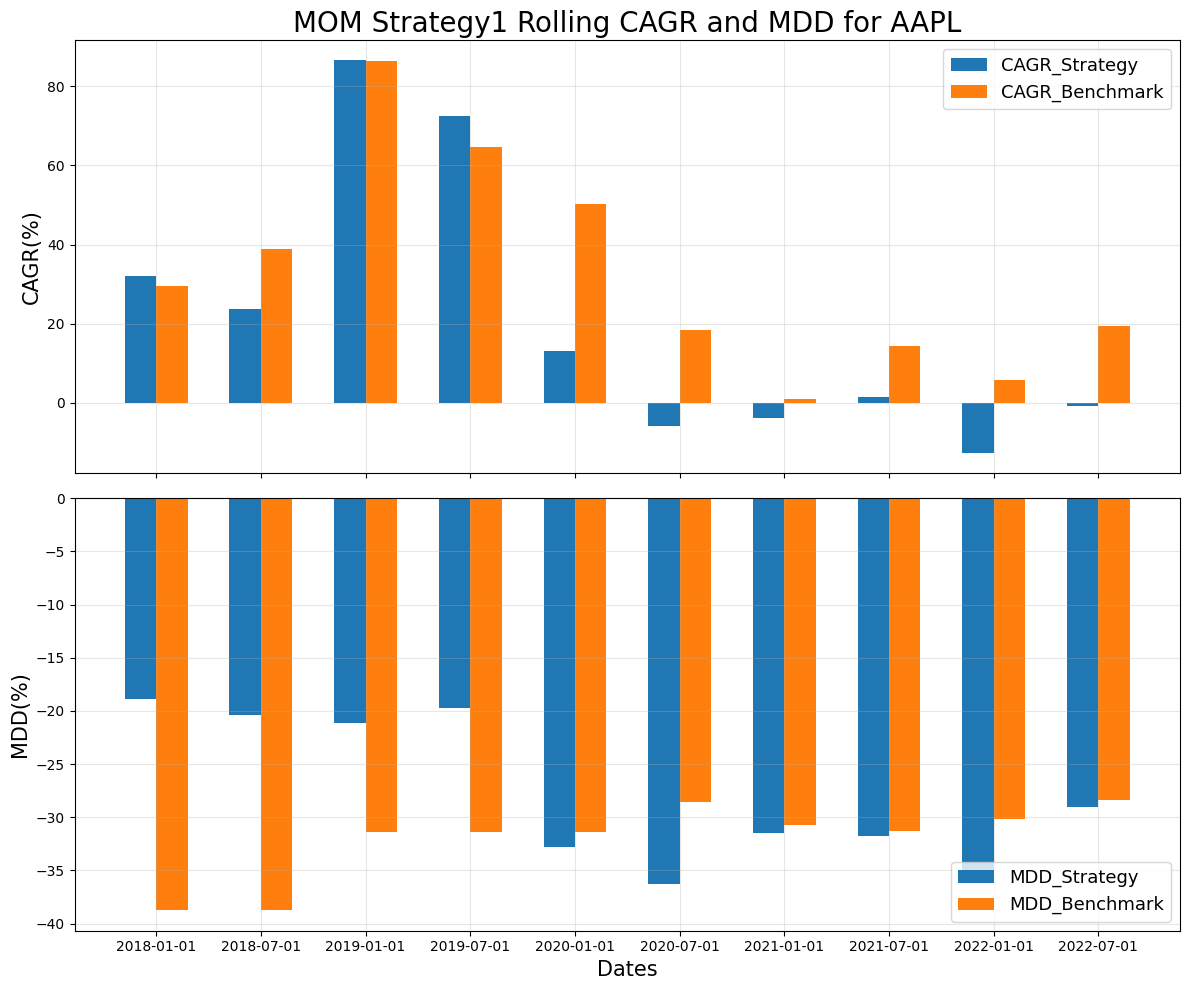

In [31]:
# Data
values1 = results_df[('Strategy','CAGR')].values
values2 = results_df[('Benchmark','CAGR')].values
values3 = results_df[('Strategy','MDD')].values
values4 = results_df[('Benchmark','MDD')].values

# Define the position of bars on x-axis
bar_width = 0.3
index = np.arange(len(dates))

# Create figure and axes with figsize
fig, ax = plt.subplots(2,1, figsize=(12, 10), sharex=True)

# Create grouped bar graph
ax[0].bar(index, values1*100, bar_width, label='CAGR_Strategy')
ax[0].bar(index + bar_width, values2*100, bar_width, label='CAGR_Benchmark')

ax[1].bar(index, values3*100, bar_width, label='MDD_Strategy')
ax[1].bar(index + bar_width, values4*100, bar_width, label='MDD_Benchmark')

# Add labels, title, and ticks
ax[0].set_ylabel('CAGR(%)', fontsize=15)
ax[0].set_title(f'MOM Strategy1 Rolling CAGR and MDD for {ticker}', fontsize=20)

ax[1].set_ylabel('MDD(%)', fontsize=15)
ax[1].set_xlabel('Dates', fontsize=15)
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(dates)
ax[0].legend(fontsize=13)
ax[1].legend(fontsize=13)
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()